## House Prices - advanced regression techniques

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [311]:
import numpy as np
import pandas as pd
import datetime
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler, RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os
import time
from tqdm import tqdm

In [268]:
train = pd.read_csv('../data/House Prices/train.csv')
test = pd.read_csv('../data/House Prices/test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

In [269]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

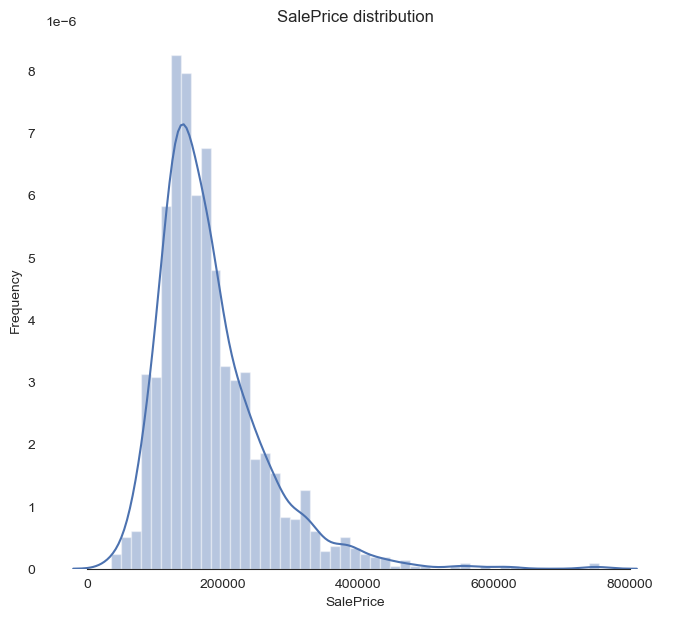

In [270]:
sns.set_style('white')
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['SalePrice'], color='b')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice distribution')
sns.despine(trim=True, left=True)
plt.show()

In [271]:
print(f"Skewness: {train['SalePrice'].skew():.5f}")
print(f"Kurtosis: {train['SalePrice'].kurt():.5f}")

Skewness: 1.88288
Kurtosis: 6.53628


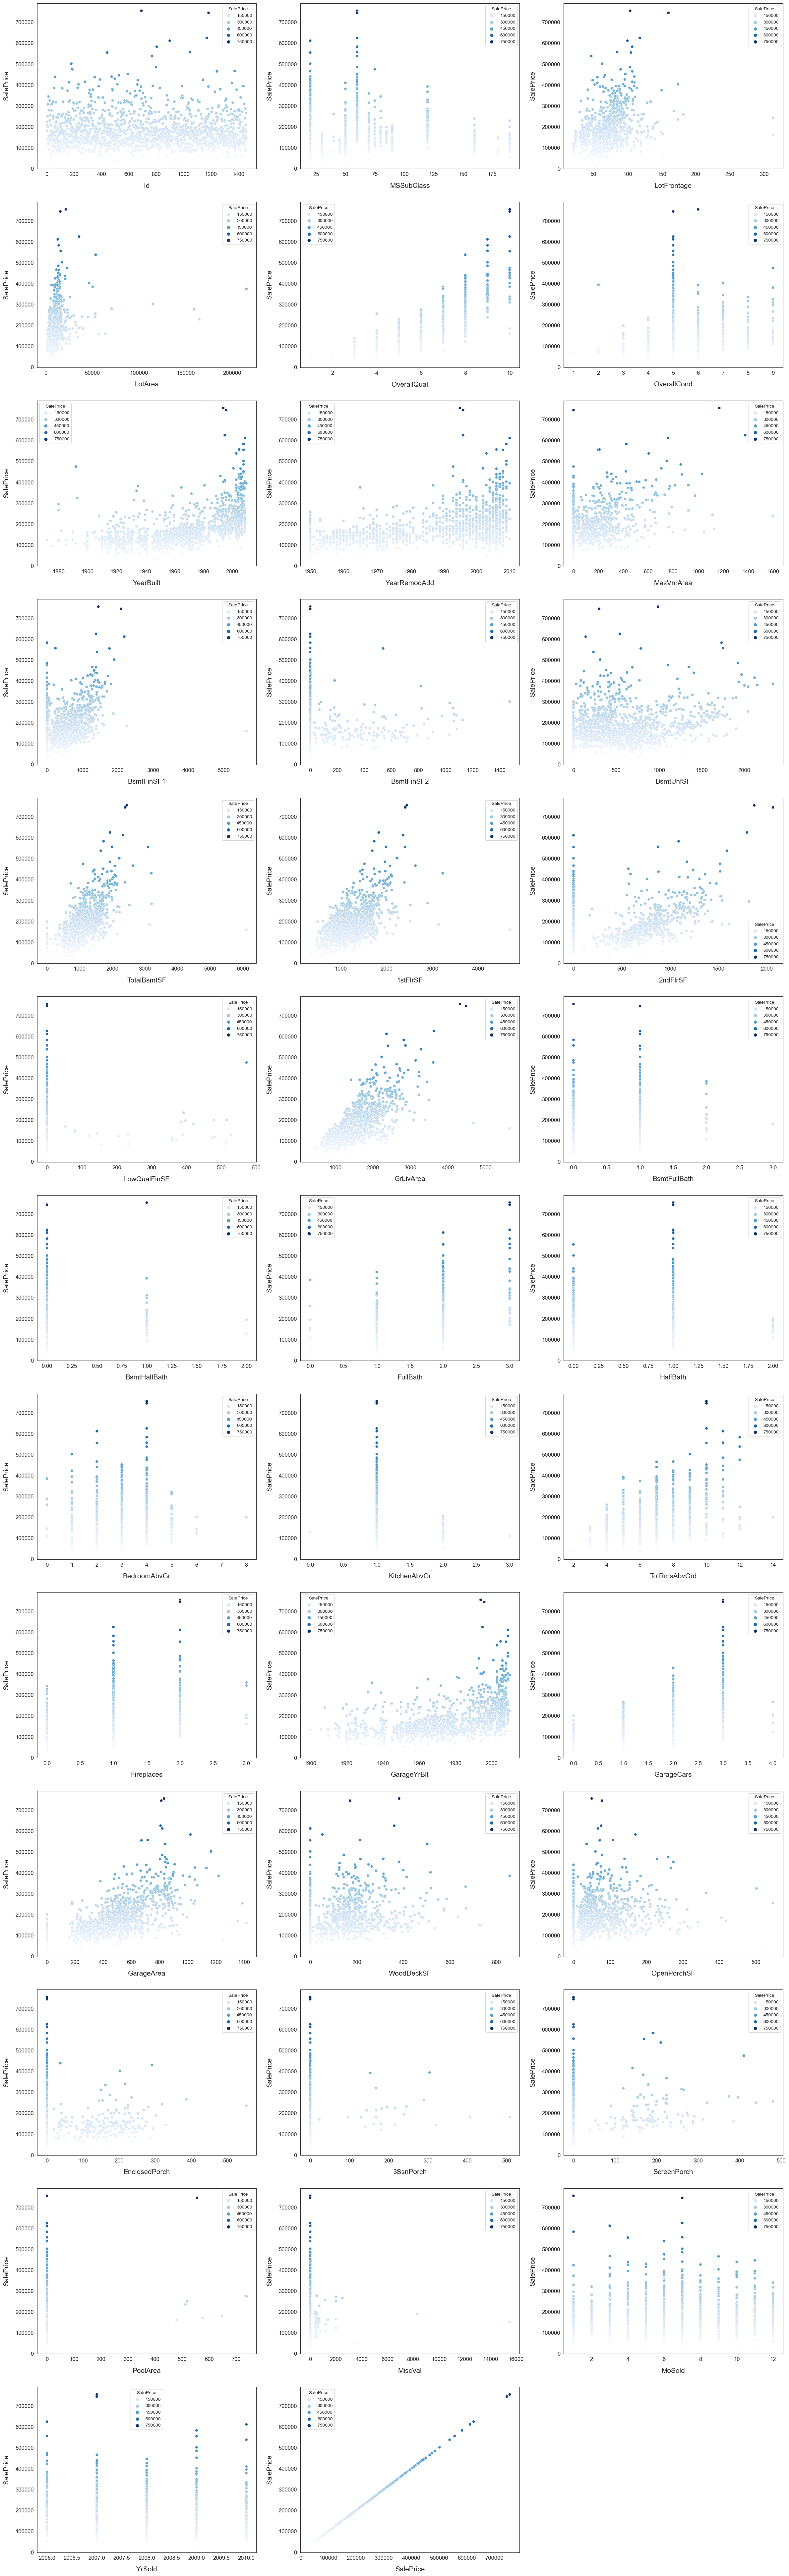

In [272]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for col in train.columns:
    if train[col].dtype in numeric_dtypes:
        numeric.append(col)
# len(numeric) = len(train.describe().columns)

fig, ax = plt.subplots(figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette('husl', 8)
for i, feature in enumerate(list(train[numeric]), 1):
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)

    plt.xlabel(feature, size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

plt.show()


<AxesSubplot:>

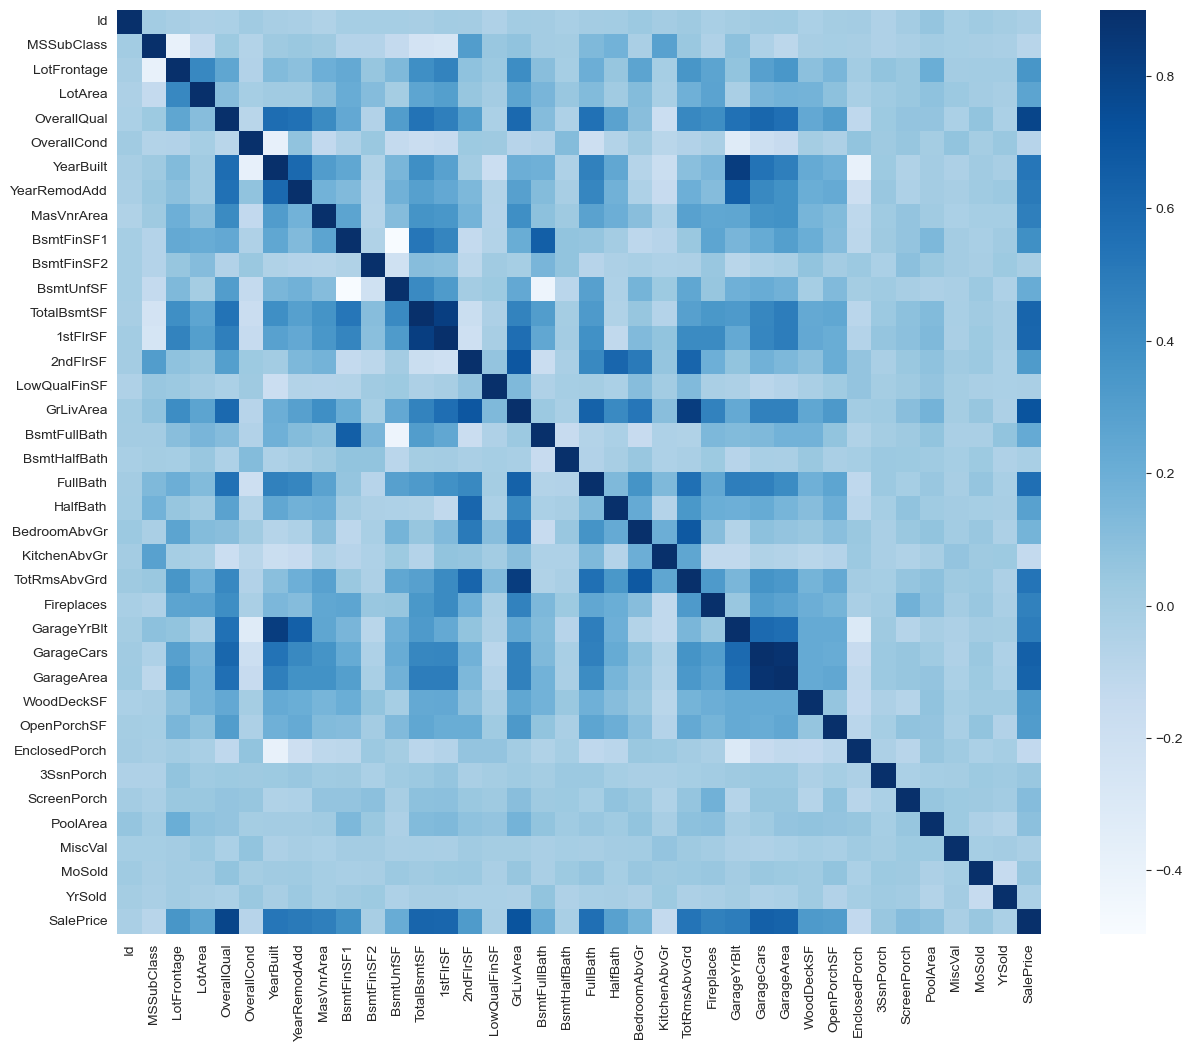

In [273]:
corr = train.corr()
plt.subplots(figsize=(15, 12))
sns.heatmap(corr, vmax=0.9, cmap='Blues', square=True)

OverallQual vs SalePrice


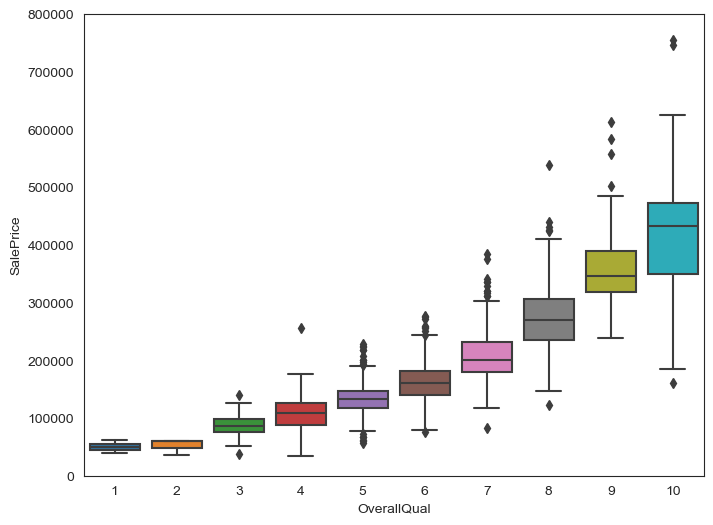

In [274]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
print('OverallQual vs SalePrice')

YearBuilt vs SalePrice


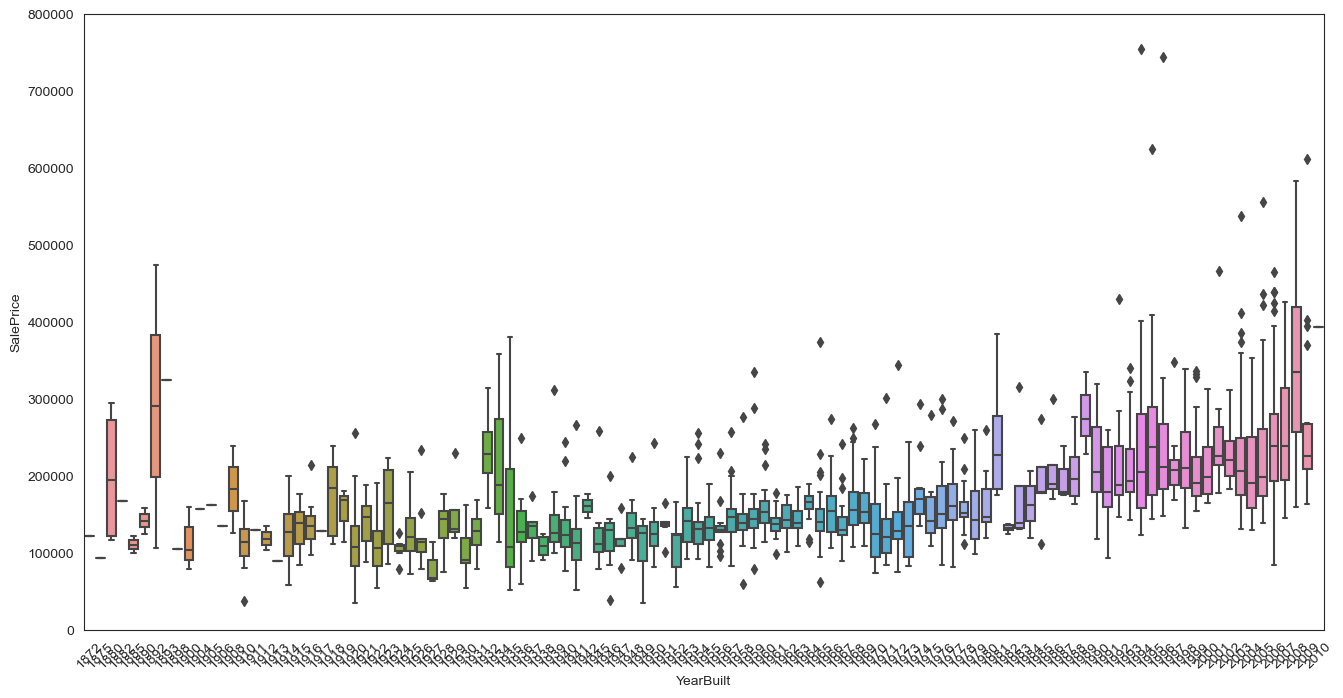

In [275]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='YearBuilt', y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=45)
print('YearBuilt vs SalePrice')

TotalBsmtSF vs SalePrice


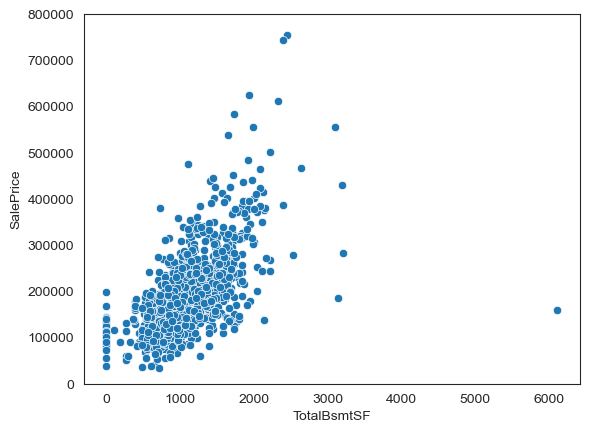

In [276]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=data)
plt.ylim(0, 800000)
print('TotalBsmtSF vs SalePrice')

LotArea vs SalePrice


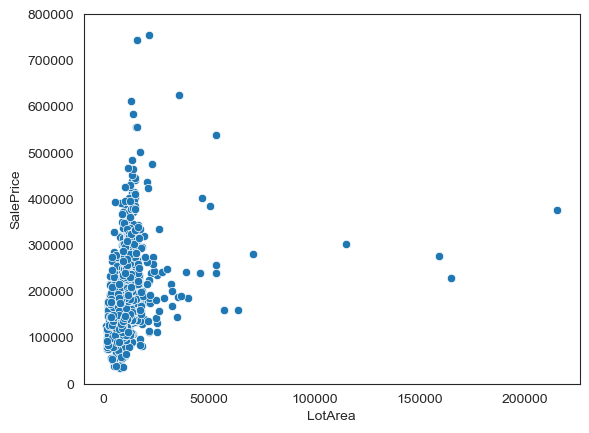

In [277]:
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)
sns.scatterplot(x='LotArea', y='SalePrice', data=data)
plt.ylim(0, 800000)
print('LotArea vs SalePrice')

GrLivArea vs SalePrice


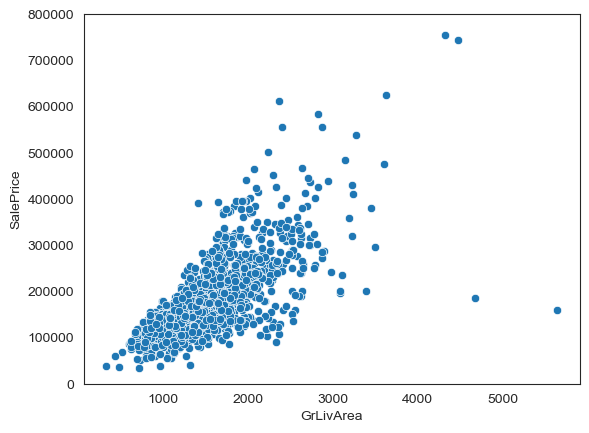

In [278]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
sns.scatterplot(x='GrLivArea', y='SalePrice', data=data)
plt.ylim(0, 800000)
print('GrLivArea vs SalePrice')

In [279]:
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape, test.shape

((1460, 80), (1459, 79))

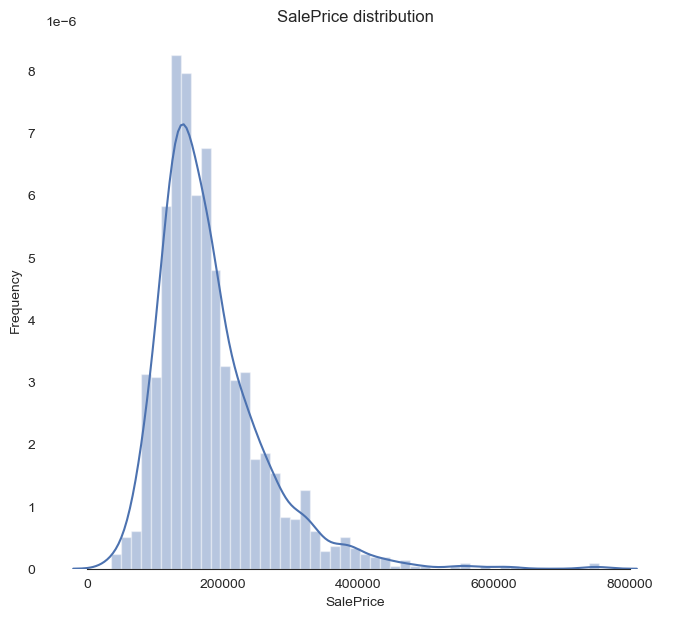

In [280]:
sns.set_style('white')
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['SalePrice'], color='b')
ax.set(ylabel='Frequency')
ax.set(title='SalePrice distribution')
sns.despine(trim=True, left=True)
plt.show()

In [281]:
train['SalePrice'] = np.log1p(train['SalePrice'])

mu = 12.02 and sigma = 0.40
Skewness: 0.12135
Kurtosis: 0.80952


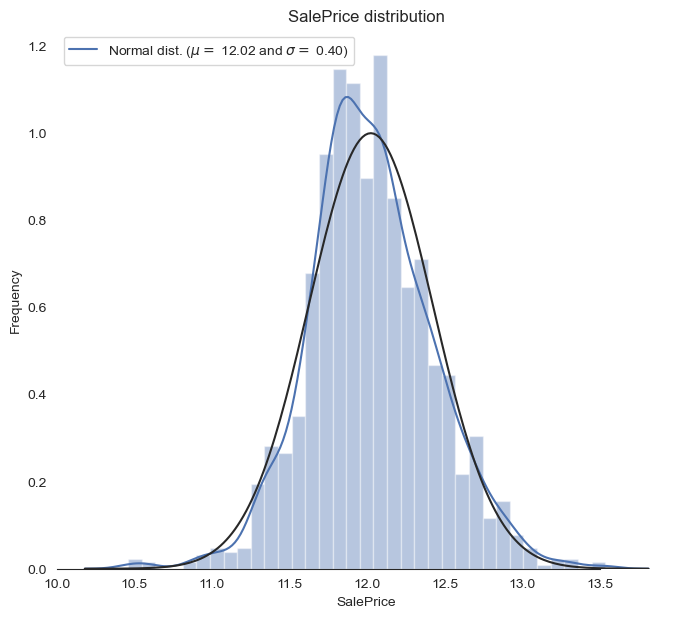

In [282]:
sns.set_style('white')
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['SalePrice'], fit=norm, color='b')

(mu, sigma) = norm.fit(train['SalePrice'])
print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f})'], loc='best')

ax.set(ylabel='Frequency')
ax.set(title='SalePrice distribution')
sns.despine(trim=True, left=True)

print(f"Skewness: {train['SalePrice'].skew():.5f}")
print(f"Kurtosis: {train['SalePrice'].kurt():.5f}")

plt.show()

In [283]:
train.drop(train[(train['OverallQual'] < 5) & (train['SalePrice'] > 200000)].index, inplace=True)
train.drop(train[(train['GrLivArea'] > 4500) & (train['SalePrice'] < 300000)].index, inplace=True)
train.drop(train[(train['TotalBsmtSF'] > 4000) & (train['SalePrice'] < 300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [284]:
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2917, 79)

In [285]:
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = data.columns
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100, 2)})

    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[:15]


Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45),
 ('GarageType', 5.38),
 ('BsmtCond', 2.81),
 ('BsmtExposure', 2.81),
 ('BsmtQual', 2.78),
 ('BsmtFinType2', 2.74)]

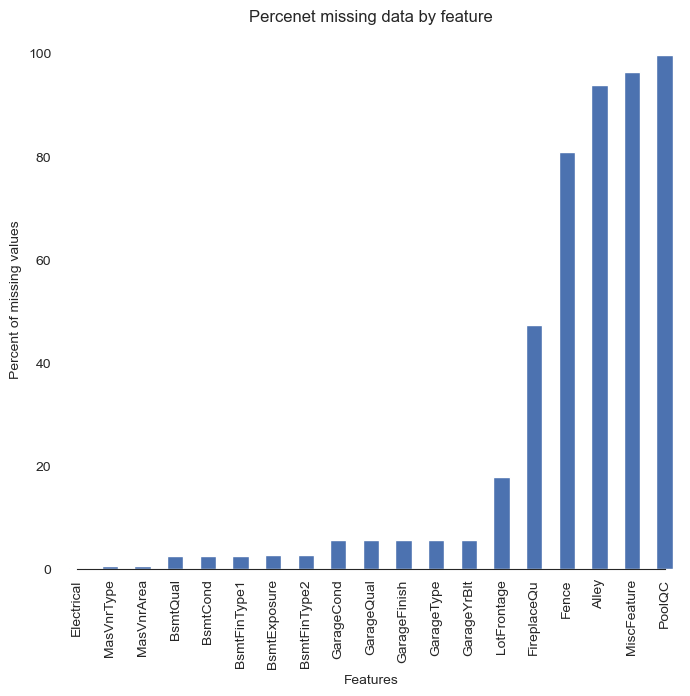

In [286]:
# sns.set_style('white')
f, ax = plt.subplots(figsize=(8, 7))
missing = round(train.isnull().mean() * 100, 2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='b')

ax.set(ylabel='Percent of missing values')
ax.set(xlabel='Features')
ax.set(title='Percenet missing data by feature')
sns.despine(trim=True, left=True)

In [287]:
def handle_missing(feat):
    feat['Functional'] = feat['Functional'].fillna('Typ')
    feat['Electrical'] = feat['Electrical'].fillna('SBrkr')
    feat['KitchenQual'] = feat['KitchenQual'].fillna('TA')

    feat['Exterior1st'] = feat['Exterior1st'].fillna(feat['Exterior1st'].mode()[0])
    feat['Exterior2nd'] = feat['Exterior2nd'].fillna(feat['Exterior2nd'].mode()[0])
    feat['SaleType'] = feat['SaleType'].fillna(feat['SaleType'].mode()[0])
    feat['MSZoning'] = feat.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

    feat['PoolQC'] = feat['PoolQC'].fillna('None')

    feat['GarageYrBlt'] = feat['GarageYrBlt'].fillna(0)
    feat['GarageArea'] = feat['GarageArea'].fillna(0)
    feat['GarageCars'] = feat['GarageCars'].fillna(0)
    feat['GarageType'] = feat['GarageType'].fillna('None')
    feat['GarageFinish'] = feat['GarageFinish'].fillna('None')
    feat['GarageQual'] = feat['GarageQual'].fillna('None')
    feat['GarageCond'] = feat['GarageCond'].fillna('None')

    feat['BsmtQual'] = feat['BsmtQual'].fillna('None')
    feat['BsmtCond'] = feat['BsmtCond'].fillna('None')
    feat['BsmtExposure'] = feat['BsmtExposure'].fillna('None')
    feat['BsmtFinType1'] = feat['BsmtFinType1'].fillna('None')
    feat['BsmtFinType2'] = feat['BsmtFinType2'].fillna('None')

    feat['LotFrontage'] = feat.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    feat['Utilities'] = feat['Utilities'].fillna('AllPub')

    for col in feat.columns:
        if feat[col].dtype == object:
            feat[col] = feat[col].fillna('None')
        elif feat[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            feat[col] = feat[col].fillna(0)
        else:
            print(f'column {col} is not matched above data types!')

    print('Filling null task completed!')

    return feat

all_features = handle_missing(all_features)

Filling null task completed!


In [288]:
# run this cell if you want non-necessary numbers into string

# for col in ['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'YrSold', 'MoSold']:
#     all_features[col] = all_features[col].astype(str)

In [289]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

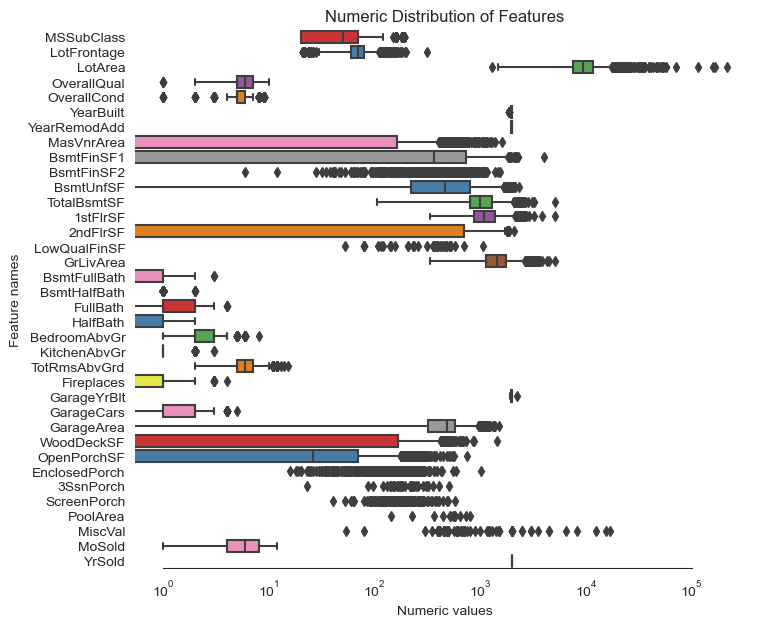

In [290]:
sns.set_style('white')
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale('log')
ax = sns.boxplot(data=all_features[numeric], orient='h', palette='Set1')
ax.set(ylabel='Feature names')
ax.set(xlabel='Numeric values')
ax.set(title='Numeric Distribution of Features')
sns.despine(trim=True, left=True)

In [291]:
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print(f'There are {high_skew.shape[0]} numerical features with Skew > 0.5 :')
skewness = pd.DataFrame({'Skew': high_skew})
skew_features.head(10)

There are 26 numerical features with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

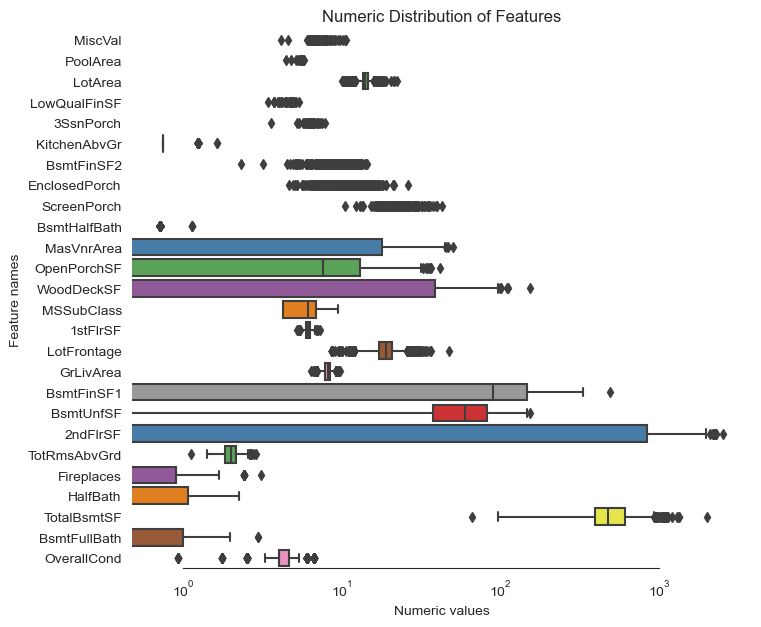

In [292]:
for col in skew_index:
    all_features[col] = boxcox1p(all_features[col], boxcox_normmax(all_features[col] + 1))

sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [293]:
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
skew_features.head(10)

PoolArea         15.595057
3SsnPorch         8.862045
LowQualFinSF      8.492615
MiscVal           5.237983
BsmtHalfBath      3.779434
KitchenAbvGr      3.778337
ScreenPorch       3.152631
BsmtFinSF2        2.578329
EnclosedPorch     2.149132
MasVnrArea        0.977618
dtype: float64

In [294]:
# Not adjust for test

# all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
# all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
# all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
# all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
# all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
# all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
# all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
# all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
# all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
# all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

# all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
#                                  all_features['1stFlrSF'] + all_features['2ndFlrSF'])
# all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
#                                all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
# all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
#                               all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
#                               all_features['WoodDeckSF'])
# all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
# all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
# all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
# all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
# all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
# all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
# all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

# all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
# all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
# all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
# all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
# all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [295]:
# Not adjust for test

def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        if l in res.columns:
          res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
          res.columns.values[m] = l + '_log'
          m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [296]:
# Not adjust for test

def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        if l in res.columns:
          res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
          res.columns.values[m] = l + '_sq'
          m += 1
    return res

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

In [297]:
all_features = pd.get_dummies(all_features)
all_features.shape

(2917, 338)

In [298]:
all_features = all_features.loc[:, ~all_features.columns.duplicated()]

In [299]:
X = all_features.iloc[:len(train_labels)]
X_test = all_features.iloc[len(train_labels):]
X.shape, train_labels.shape, X_test.shape

((1458, 338), (1458,), (1459, 338))

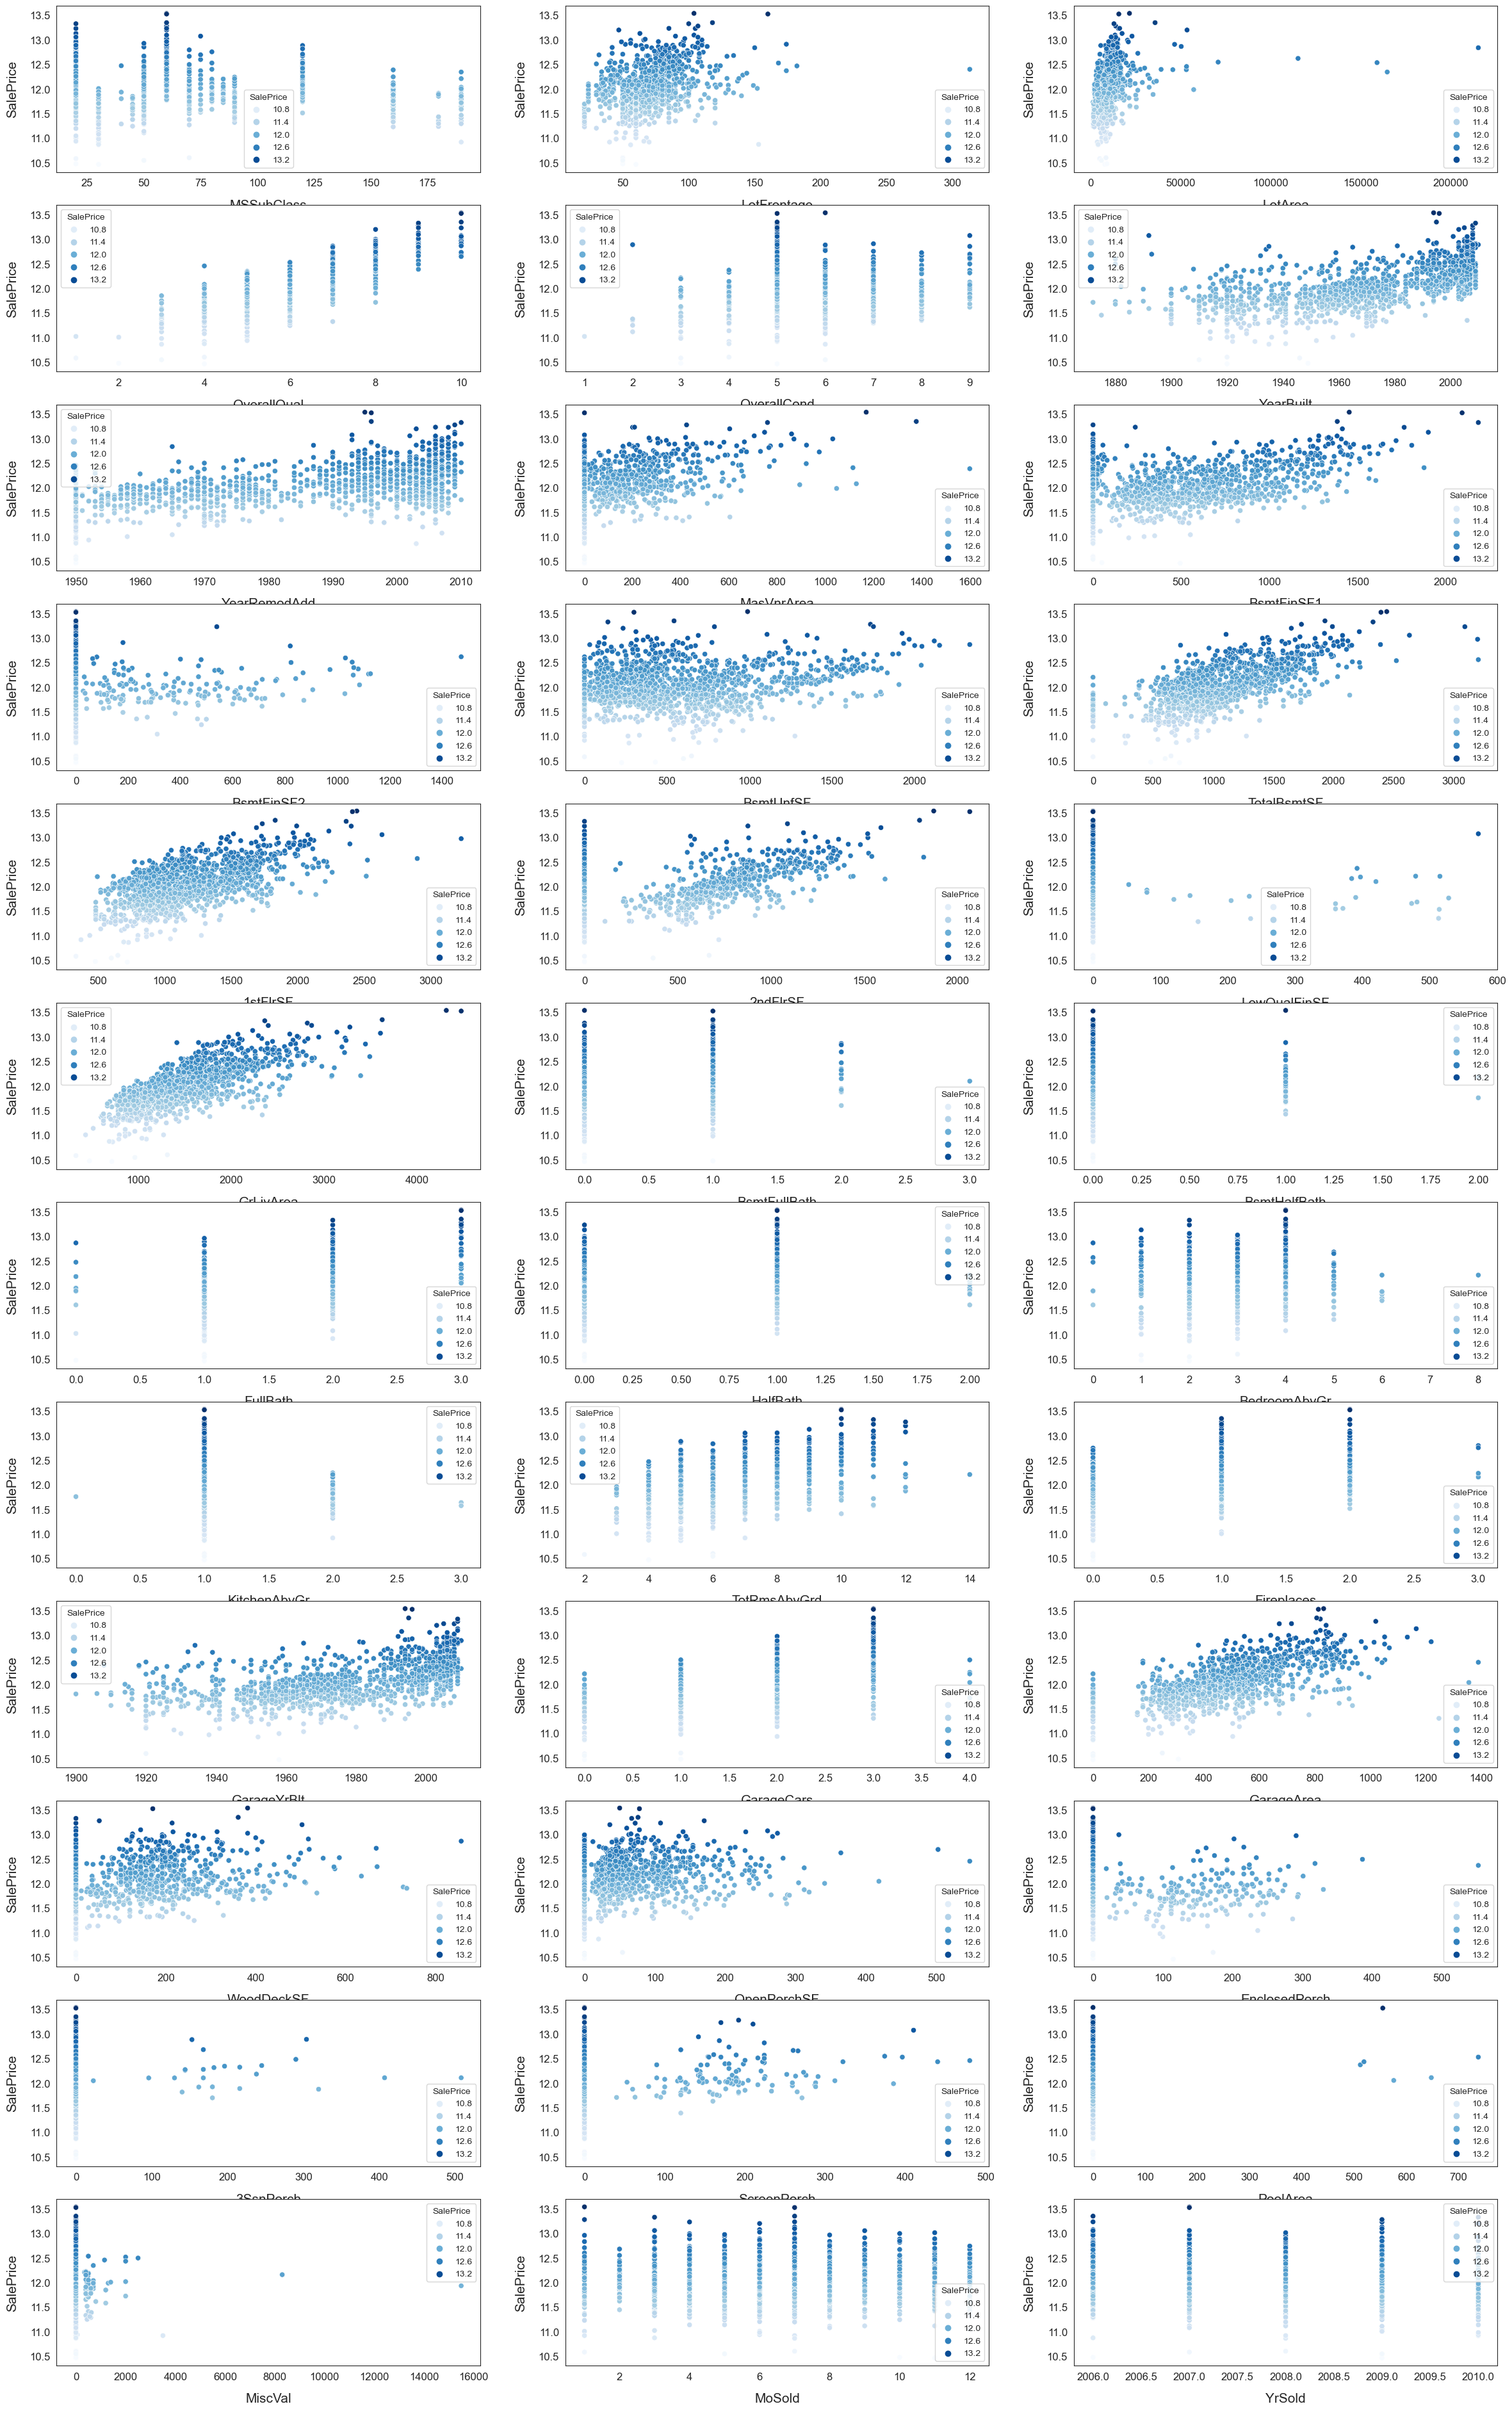

In [300]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for col in X.columns:
    if X[col].dtype in numeric_dtypes:
        numeric.append(col)

fig, ax = plt.subplots(figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette('husl', 8)
for i, feature in enumerate(list(X[numeric]), 1):
    if feature not in train.columns:
        continue

    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)

    plt.xlabel(feature, size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

plt.show()

In [400]:
train_x = X.to_numpy()
train_y = train_labels.to_numpy()
test_x = X_test.to_numpy()
train_x.shape, train_y.shape, test_x.shape

((1458, 338), (1458,), (1459, 338))

In [401]:
# Define classifiers
regressors = {
    # 'XGBoost': XGBRegressor(),
    # 'Ridge': Ridge(),
    'SVR': SVR(),
    # 'RF': RandomForestRegressor(),
    # 'GBR': GradientBoostingRegressor()
}

# Grid search
SVR_grid = {
    'C': [1, 2.5, 5, 10, 25],
    'kernel': ['rbf'],
    'gamma': [0.0001],
    'epsilon': [0.005]
}
RF_grid = {
    'n_estimators': [100, 200, 500, 700, 1000, 1200, 1500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [3, 5, 10]
}
boosted_grid = {
    'n_estimators': [100, 500, 1000, 3000, 6000],
    'max_depth': [4, 8, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}
Ridge_grid = {
    'alpha': [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100],
    'max_iter': [100, 500, 1000, 3000, 5000]
}

grids = {
    'XGBoost': boosted_grid,
    'Ridge': Ridge_grid,
    'SVR': SVR_grid,
    'RF': RF_grid,
    'GBR': boosted_grid
}

In [402]:
# define cross_validation Fold
n_fold = 8
cv = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [403]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [404]:
# Parameter study with/without kfold
reg_best_params = regressors.copy()
valid_scores = pd.DataFrame({
    'Regressor': regressors.keys(),
    'Validation metric': np.zeros(len(regressors)),
    'Training time': np.zeros(len(regressors))
})

for i, (key, regressor) in tqdm(enumerate(regressors.items()), total=len(regressors.keys())):
    start_time = time.time()

    reg = GridSearchCV(
        estimator=regressor,
        param_grid=grids[key],
        cv=cv,
        verbose=1
    )

    reg.fit(train_x, train_y)
    valid_scores.iloc[i, 1] = reg.best_score_

    reg_best_params[key] = reg.best_params_

    end_time = time.time()
    valid_scores.iloc[i, 2] = np.round((end_time - start_time) / 60, 2)

for i, (key, regressor) in enumerate(regressors.items()):
    print(f"Model {key} training time(min): {valid_scores.iloc[i, 2]}")


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 8 folds for each of 5 candidates, totalling 40 fits


100%|██████████| 1/1 [00:12<00:00, 12.99s/it]

Model SVR training time(min): 0.22


In [405]:
valid_scores

Regressor  Validation metric  Training time
0       SVR           0.316259           0.22

In [406]:
reg_best_params

{'SVR': {'C': 2.5, 'epsilon': 0.005, 'gamma': 0.0001, 'kernel': 'rbf'}}

In [407]:
best_regressors = {
    # 'XGBoost': XGBRegressor(**reg_best_params['XGBoost']),
    # 'Ridge': make_pipeline(RobustScaler(), Ridge(**reg_best_params['Ridge'])),
    'SVR': make_pipeline(RobustScaler(), SVR(**reg_best_params['SVR'])),
    # 'RF': RandomForestRegressor(**reg_best_params['RF']),
    # 'GBR': GradientBoostingRegressor(**reg_best_params['GBR'])
}

In [408]:
preds = np.zeros(len(test_x))
for key, regressor in best_regressors.items():
    print('Start', key)
    start = time.time()

    score=0
    for fold, (train_idx, val_idx) in tqdm(enumerate(cv.split(train_x, train_y)), desc=key, total=n_fold):
        X_train_small, X_val_small = train_x[train_idx], train_x[val_idx]
        y_train_small, y_val_small = train_y[train_idx], train_y[val_idx]

        regressor.fit(X_train_small, y_train_small)

        preds += regressor.predict(test_x)
        score += rmsle(regressor.predict(X_val_small), y_val_small)

    score = score / n_fold

    stop = time.time()

    print('Model:', key)
    print('Average validation metric:', np.round(score, 3))
    print('Training time (mins):', np.round((stop - start) / 60, 2))
    print('')

preds = preds / (n_fold * len(best_regressors))

Start SVR


SVR: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]

Model: SVR
Average validation metric: 0.124
Training time (mins): 0.1



In [409]:
submission = pd.DataFrame({'Id': range(1461, 1461 + len(X_test)), 'SalePrice': np.floor(np.expm1(preds))})
submission.head(), submission.tail()

(     Id  SalePrice
 0  1461   120494.0
 1  1462   153695.0
 2  1463   191247.0
 3  1464   206101.0
 4  1465   180904.0,
         Id  SalePrice
 1454  2915    89368.0
 1455  2916    93602.0
 1456  2917   184809.0
 1457  2918   114739.0
 1458  2919   229697.0)

In [371]:
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x * 0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x * 1.1)

submission.to_csv('../submissions/house-prices/submission_Ridge_3.csv', index=False)

In [227]:
# # for reference

# lightgbm = LGBMRegressor(
#     objective='regression',
#     num_leaves=6,
#     learning_rate=0.01,
#     n_estimators=7000,
#     max_bin=200,
#     bagging_fraction=0.8,
#     bagging_freq=4,
#     bagging_seed=8,
#     feature_fraction=0.2,
#     feature_fraction_seed=8,
#     min_sum_hessian_in_leaf=11,
#     verbose=-1,
#     random_state=42
# )

# xgboost = XGBRegressor(
#     learning_rate=0.01,
#     n_estimators=6000,
#     max_depth=4,
#     min_child_weight=0,
#     gamma=0.6,
#     subsample=0.7,
#     colsample_bytree=0.7,
#     objective='reg:squarederror',
#     nthread=-1,
#     scale_pos_weight=1,
#     seed=27,
#     reg_alpha=0.00006,
#     random_state=42
# )

# ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
# ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))

# gbr = GradientBoostingRegressor(
#     n_estimators=6000,
#     learning_rate=0.01,
#     max_depth=4,
#     max_features='sqrt',
#     min_samples_leaf=15,
#     min_samples_split=10,
#     loss='huber',
#     random_state=42
# )

# rf = RandomForestRegressor(
#     n_estimators=1200,
#     max_depth=15,
#     min_samples_leaf=5,
#     min_samples_split=5,
#     max_features=None,
#     oob_score=True,
#     random_state=42
# )

# stack_gen = StackingCVRegressor(
#     regressors=(xgboost, svr, ridge, gbr, rf),
#     meta_regressor=xgboost,
#     use_features_in_secondary=True
# )